# shot selection

Hypothesis: When certain players are in the game, they distort the shot selection of the team they are playing.

In [1]:
# Parameters that you can use to adjust.
pickteam = "LAC"
numberofgames = 30

In [2]:
# from bs4 import BeautifulSoup as bs
import urlopen
import urllib
import re
import pandas as pd
import numpy as np
import json

%matplotlib inline
from matplotlib.patches import Circle, Rectangle, Arc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb

# for the api part.
import requests
import base64
import configparser

# let's be secure and keep authorization details secret.
APIKEYS = configparser.ConfigParser()
APIKEYS.read('./APIKeys.ini');

# Get the keyname (client_id?) and actual API key.
usern = APIKEYS['mysportsfeeds']['usern']
passw = APIKEYS['mysportsfeeds']['passw']

200


['./APIKeys.ini']

In [3]:
# Let's make a function so that our loop can be simpler.
def getShots(allplays, team):
    
    num_plays = allplays.shape[0]
    
    # we really only care about fieldGoalAttempts and 
    for i in range(num_plays):
        allplays.loc[i,'pt0'] = list(allplays['play'][i].keys())[0]
        allplays.loc[i,'pt1'] = list(allplays['play'][i].keys())[1]
        allplays.loc[i,'pt2'] = list(allplays['play'][i].keys())[2]
        allplays.loc[i,'playTime']  = allplays['play'][i]['time']
        allplays.loc[i,'q'] = int(allplays['play'][i]['quarter'])
    
    # Let's align the time correctly.
    allplays = allplays.assign(time = pd.to_datetime(allplays['playTime'], format='%M:%S').dt.time)

    # And get it in seconds.
    for i in range(num_plays): 
        allplays.loc[i,'secs'] = (int(allplays['q'][i]) - 1)*720 + allplays['time'][i].minute*60 + allplays['time'][i].second

    allplays.loc[ allplays['pt0'].isin(["quarter","time"]) , 'pt0'] = ""
    allplays.loc[ allplays['pt1'].isin(["quarter","time"]) , 'pt1'] = ""
    allplays.loc[ allplays['pt2'].isin(["quarter","time"]) , 'pt2'] = ""

    # simplify things a little
    allplays = allplays.assign(playType = allplays['pt0'] + allplays['pt1'] + allplays['pt2'])
    # drop the variables we made.
    allplays = allplays.drop(['pt0','pt1','pt2'],1)

    # These are the types.
    SorF = ['freeThrowAttempt', 'fieldGoalAttempt', 'foul']

    # we really only care about fieldGoalAttempts and fouls/free throws
    sfft = allplays.loc[allplays['playType'].isin(SorF),:]
    
    # first we only care about field goal attempts.
    shots = allplays.loc[allplays['playType'] == 'fieldGoalAttempt']

    # so we gotta drop the index.
    sfft = sfft.reset_index(drop=True)
    shots = shots.reset_index(drop=True)

    num_sfft = sfft.shape[0]
    num_shots = shots.shape[0]

#   This is what the play format is (if it's a field goal attempt)
#     {'Points': '2',
#  'distanceFeet': '9',
#  'outcome': 'SCORED',
#  'shootingPlayer': {'FirstName': 'Evan',
#   'ID': '9399',
#   'JerseyNumber': '10',
#   'LastName': 'Fournier',
#   'Position': 'SG'},
#  'shotLocation': {'x': '137', 'y': '243'},
#  'shotType': 'Driving Finger Roll Layup',
#  'teamAbbreviation': 'ORL'}
    
    for i in range(num_shots): 
#         shots.loc[i,'fGmade']    = int( shots['play'][i][shots['playType'][i]]['outcome'] == "SCORED" )
        shots.loc[i,'fGoutcome'] = shots['play'][i][shots['playType'][i]]['outcome'] 
        shots.loc[i,'fGdistance'] = int( shots['play'][i][shots['playType'][i]]['distanceFeet'] )
        shots.loc[i,'fGval']     = int( shots['play'][i][shots['playType'][i]]['Points'] )
        shots.loc[i,'fGshooter'] = int( shots['play'][i][shots['playType'][i]]['shootingPlayer']['ID'] )
        try: 
            shots.loc[i,'fGlocX']    = int( shots['play'][i][shots['playType'][i]]['shotLocation']['x'] ) 
            shots.loc[i,'fGlocY']    = int( shots['play'][i][shots['playType'][i]]['shotLocation']['y'] ) - 250
        except:
            shots.loc[i,'fGlocX'] = np.NaN
            shots.loc[i,'fGlocY'] = np.NaN
        shots.loc[i,'fGtype']    = ( shots['play'][i][shots['playType'][i]]['shotType'] )

        if type(team) is str:
             shots.loc[i,'fGteam']    = int( shots['play'][i][shots['playType'][i]]['teamAbbreviation'] == team )
        else:
             shots.loc[i,'fGteam']    = ''
        
    # Make the dataset a little neater...
    shots = shots.drop(['play','playTime','playType'],1)

    # Hmm... locations here are absolute. So we have to figure out home/away.
    shots = shots.assign( locX = (shots['fGlocX'])*(shots['fGlocX'] < 470) + (940 - shots['fGlocX'])*(shots['fGlocX'] >= 470) - 470 )

    # Let's flatten by time.
#     candidates = shots.groupby(['gameno','q','secs'], as_index=False).sum()
    
    # Restrict to the team you're interested in... if there is no team then you pick all.
    if type(team) is str:
        shots = shots.loc[ (shots['fGteam'] == 1) ]

    return shots

In [5]:
def getTeamSchedule(pickteam, numberofgames):
    
    team_url = "https://api.mysportsfeeds.com/v1.1/pull/nba/2017-2018-regular/team_gamelogs.json?team=" + pickteam
    team_raw =  requests.get(url=team_url,
                             headers={"Authorization": "Basic " + 
                                      base64.b64encode('{}:{}'.format(usern,passw).encode('utf-8')).decode('ascii')})

    # Just in case!
    print("URL API status: " + str(team_raw.status_code))

    # Convert to JSON
    team_js = team_raw.json()

    # Now we have the schedule.
    team_sked_raw = pd.DataFrame(team_js['teamgamelogs']['gamelogs'])
    team_sked = pd.DataFrame(columns=['away','home','gamedate'])


    # team_sked_raw.loc[:,'game']
    # Loop over the games and get the correct ID (YYYYMMDD-AWAY-HOME)
    for i in range(numberofgames):
        team_sked.loc[i,:] =  [team_sked_raw.loc[i,'game']['awayTeam']['Abbreviation'],   
                               team_sked_raw.loc[i,'game']['homeTeam']['Abbreviation'], 
                               team_sked_raw.loc[i,'game']['date'].replace("-","")]

    team_sked = team_sked.assign(gameid = team_sked['gamedate'] + "-" + team_sked['away'] + "-" + team_sked['home'])
    # team_sked = team_sked.drop(['game','stats','team'], 1)
    team_urls = team_sked.drop(['away','home','gamedate'], 1)
    team_urls = team_urls.assign(gameURL = "https://api.mysportsfeeds.com/v1.1/pull/nba/2017-2018-regular/game_playbyplay.json?gameid=" + 
                                 team_sked['gameid'] )
#     return team_js
    return team_urls

#####################################

def getTeamPlays(pickteam, team_urls):
    statuses = []
    shots_season = pd.DataFrame()
    
    numberofgames = len(team_urls)
    
    # Loop over games... the number of games parameter is chosen above.
    for i in range(numberofgames):
        team_games =  requests.get(
                    url=team_urls['gameURL'][i],
                    headers={"Authorization": "Basic " + base64.b64encode('{}:{}'.format(usern,passw).encode('utf-8')).decode('ascii')}
                    )

        statuses.append(team_games.status_code)
        print("Game " + str(i+1) + ": " + team_urls['gameid'][i])

        game_js = team_games.json()

        # Make sure you get the play data.
        allplays = pd.DataFrame(game_js['gameplaybyplay']['plays'])
        allplays = allplays.assign( gameno = i )
        
        # Call the function and get all of the and-ones...
        gameshots = getShots(allplays,pickteam)
    
        # Append after each game to make a season-long dataset.
        shots_season = shots_season.append(gameshots,ignore_index=True)
    
#     return statuses, allplays
    return statuses, shots_season

In [6]:
# Shamelessly adapted from http://savvastjortjoglou.com/nba-shot-sharts.html (and rotated to landscape...)
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    outer_box = Rectangle((-470, -80), 190, 160, linewidth=lw, color=color, fill=False)

    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((-417.5, 0), 80, 80, theta1=270, theta2=90, linewidth=lw, color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-470, 220), 140, 0, linewidth=lw, color=color)
    corner_three_b = Rectangle((-470, -220), 140, 0, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the threes
    three_arc = Arc((-417.5, 0), 475, 475, theta1=292, theta2=68, linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [outer_box, restricted, corner_three_a, corner_three_b, three_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [7]:
team_urls = getTeamSchedule(pickteam, numberofgames)
statuses, shots_allgames = getTeamPlays(pickteam, team_urls)


URL API status: 200
Game 1: 20171019-LAC-LAL
Game 2: 20171021-PHX-LAC
Game 3: 20171024-UTA-LAC
Game 4: 20171026-LAC-POR
Game 5: 20171028-DET-LAC
Game 6: 20171030-GSW-LAC
Game 7: 20171101-DAL-LAC
Game 8: 20171104-MEM-LAC
Game 9: 20171105-MIA-LAC
Game 10: 20171107-LAC-SAS
Game 11: 20171110-LAC-OKL
Game 12: 20171111-LAC-NOP
Game 13: 20171113-PHI-LAC
Game 14: 20171117-LAC-CLE
Game 15: 20171118-LAC-CHA
Game 16: 20171120-LAC-NYK
Game 17: 20171122-LAC-ATL
Game 18: 20171125-LAC-SAC
Game 19: 20171127-LAL-LAC
Game 20: 20171130-UTA-LAC
Game 21: 20171202-LAC-DAL
Game 22: 20171203-LAC-MIN
Game 23: 20171206-MIN-LAC
Game 24: 20171209-WAS-LAC
Game 25: 20171211-TOR-LAC
Game 26: 20171213-LAC-ORL
Game 27: 20171215-LAC-WAS
Game 28: 20171216-LAC-MIA
Game 29: 20171218-LAC-SAS
Game 30: 20171220-PHX-LAC


0.0     1974
1.0      103
6.0       97
2.0       94
5.0       83
3.0       43
4.0       40
27.0      22
7.0       22
8.0       17
20.0      16
9.0       15
10.0       5
28.0       3
70.0       1
30.0       1
Name: fGdistance, dtype: int64


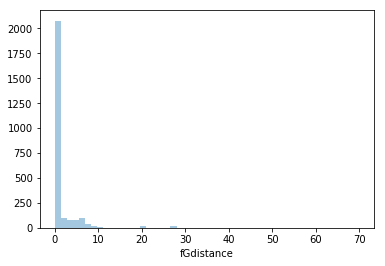

In [8]:
# gameno, q, time, secs, fGoutcome, fGdistance, fGval, fGshooter, fGlocX, fGlocY, fGtype, fGteam, locX
print(shots_allgames['fGdistance'].value_counts())
sb.distplot(shots_allgames['fGdistance'], kde=False)

In [9]:
player_url = "https://api.mysportsfeeds.com/v1.1/pull/nba/2017-2018-regular/cumulative_player_stats.JSON?playerstats=2PA,2PM,3PA,3PM,FTA,FTM"

# You can pass a parameter with the teamname.
team_player =  requests.get(
                url=player_url,
                params = {"team": pickteam},
                headers={"Authorization": "Basic " + base64.b64encode('{}:{}'.format(usern,passw).encode('utf-8')).decode('ascii')}
            )

# Again, just in case.
print(team_player.status_code)

# Construct the dataframes!
team_player = team_player.json()
team_player = pd.DataFrame(team_player['cumulativeplayerstats']['playerstatsentry'])
players = pd.DataFrame(team_player['player'])
playerstats = pd.DataFrame(team_player['stats'])

200


In [26]:
# This is Steph.
# shots_allgames = shots_allgames.loc[ shots_allgames['fGshooter'] == 9218, :]



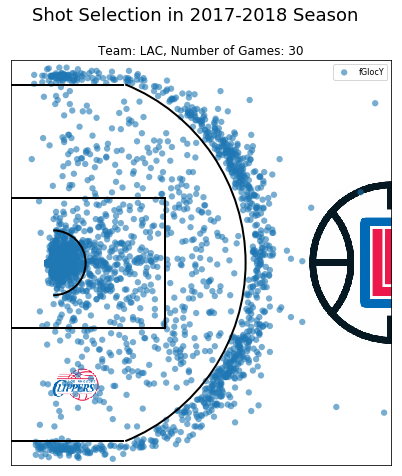

In [38]:
num_shots = shots_allgames.shape[0]

plt.figure(figsize=(7,7.45))

# Unique category labels: 'D', 'F', 'G', ...
# color_labels = andoneplayer['ID'].unique()
# name_labels = andoneplayer['last2'].unique()

# List of RGB triplets
# rgb_values = sb.color_palette("Set1", 17)

# Map label to RGB
# color_map = dict(zip(color_labels, rgb_values))

# Count the total number.
# numandones = andoneplayer.shape[0]
# labels = [andoneplayer['last2'][i] for i in range(numandones)]

# We'll map the scatter by player
# for i in range(andoneplayer['last2'].unique().shape[0]):
#     andonesforhim = andoneplayer.loc[ (andoneplayer['last2'] == name_labels[i]) , : ]
#     scatter = plt.scatter(andonesforhim.locX, andonesforhim.fGlocY, 
#                       c=andonesforhim['ID'].map(color_map), 
#                       alpha=0.6, s=40, edgecolors='none', label= name_labels[i])

scatter = plt.scatter(shots_allgames.locX, shots_allgames.fGlocY, # c=andonesforhim['ID'].map(color_map), 
                      alpha=0.6, s=40, edgecolors='none'); #, label= name_labels[i])

draw_court(outer_lines=False);

plt.xlim(-470,0);
plt.ylim(-250,250);

# I think these are the only two weird cases.
if pickteam == "OKL":
    teamname = "OKC"
elif pickteam == "BRO":
    teamname = "BKN"
else:
    teamname = pickteam

# let's rip some logos from the internet (sorry espn and yahoo)
imgurl = "http://a.espncdn.com/combiner/i?img=/i/teamlogos/nba/500/" + teamname + ".png"
img2   = "http://l.yimg.com/xe/i/us/sp/v/nba/teams/83/70x70/" + teamname.lower() + ".png"
f = urllib.request.urlopen(imgurl)
g = urllib.request.urlopen(img2)

# plot them on our half court.
a = plt.imread(f)
b = plt.imread(g)
plt.imshow(a, zorder=0, extent=[-120, 120, -120, 120]);
plt.imshow(b, origin = 'lower', zorder=0, extent=[-420, -360, -120, -180]);

# Clean up the axes.
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    left ='off',
    labelleft ='off',
    top='off',         # ticks along the top edge are off
    labelbottom='off'); # labels along the bottom edge are off

leg = plt.legend(fontsize=8, frameon=True)

frame = leg.get_frame()
frame.set_facecolor('white')

plt.suptitle("Shot Selection in 2017-2018 Season", fontsize = 18)
plt.title("Team: " + pickteam + ", Number of Games: " + str(numberofgames));

# Plot
plt.show();

plt.savefig( pickteam + "_" + str(numberofgames) + "games.png");